In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import cv2 as cv
from tensorflow import keras
from keras import layers
from keras.models import Sequential
import pathlib
from tqdm import tqdm
from keras.models import Model

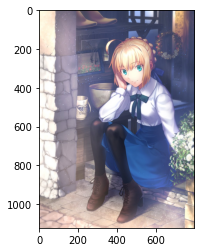

In [ ]:
image_rin = cv.imread('/content/drive/MyDrive/DataSet/Rin Tohsaka/8b2d2b0f2efb37925f40cf85d3248ff8.png')
image_rin = cv.cvtColor(image_rin, cv.COLOR_BGR2RGB)
plt.imshow(image_rin)
image_saber = cv.imread('/content/drive/MyDrive/DataSet/Saber/20210904_062250.jpg')
image_saber = cv.cvtColor(image_saber, cv.COLOR_BGR2RGB)
plt.imshow(image_saber)

In [ ]:
data_dir = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/DataSet')
data_dir = pathlib.Path('/content/drive/MyDrive/DataSet')
print(data_dir)
print(os.path.abspath(data_dir))

Found 410 files belonging to 4 classes.
/content/drive/MyDrive/DataSet
/content/drive/MyDrive/DataSet


In [ ]:
image_count = len(list(data_dir.glob('*/*')))
print(image_count)

418


In [ ]:
Rins = list(data_dir.glob('Rin Tohsaka/*'))
Ereshkigal = list(data_dir.glob('Ereshkigal/*'))
Ishtar = list(data_dir.glob('Ishtar/*'))
Saber = list(data_dir.glob('Saber/*'))

In [ ]:
total = Rins + Ereshkigal + Ishtar + Saber

In [ ]:
x = 100000
y = 100000
dslen = len(total)

In [ ]:
for i in tqdm(range(dslen)):
  t = PIL.Image.open(str(total[i]))
  xm, ym = t.size
  if xm < x:
    x = xm
  if ym < y:
    y = ym

100%|██████████| 418/418 [00:00<00:00, 577.56it/s]


In [ ]:
print(x)
print(y)

292
298


In [ ]:
batch_size = 16
img_height = 290
img_width = 290

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 410 files belonging to 4 classes.
Using 328 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 410 files belonging to 4 classes.
Using 82 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Ereshkigal', 'Ishtar', 'Rin Tohsaka', 'Saber']


In [ ]:
Eriimg = PIL.Image.open(str(Ereshkigal[0]))
Rinimg = PIL.Image.open(str(Rins[0]))
Saberimg = PIL.Image.open(str(Saber[0]))
Ishtarimg = PIL.Image.open(str(Ishtar[0]))

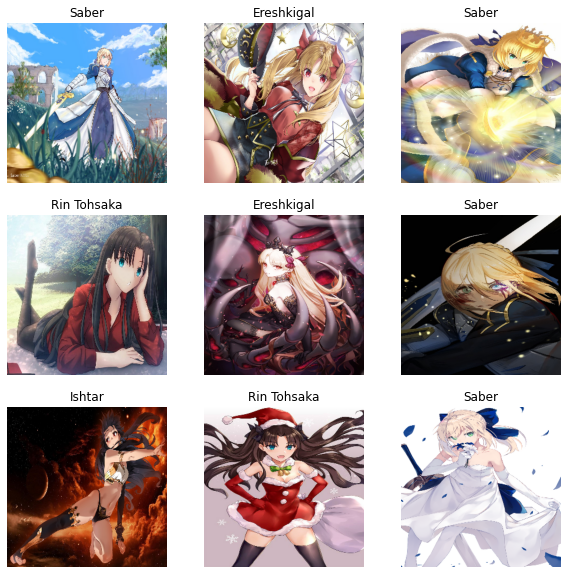

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 290, 290, 3)
(16,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [ ]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_17 (Sequential)  (None, 290, 290, 3)       0         
                                                                 
 rescaling_15 (Rescaling)    (None, 290, 290, 3)       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 290, 290, 16)      448       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 145, 145, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 145, 145, 32)      4640      
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 72, 72, 32)       0         
 g2D)                                                

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
21/21 [==============================] - 5s 171ms/step - loss: 1.9564 - accuracy: 0.3232 - val_loss: 1.3161 - val_accuracy: 0.3049
Epoch 2/10
21/21 [==============================] - 1s 65ms/step - loss: 1.2279 - accuracy: 0.3720 - val_loss: 1.1622 - val_accuracy: 0.4146
Epoch 3/10
21/21 [==============================] - 1s 65ms/step - loss: 1.1035 - accuracy: 0.4024 - val_loss: 1.2121 - val_accuracy: 0.4268
Epoch 4/10
21/21 [==============================] - 1s 65ms/step - loss: 1.1083 - accuracy: 0.4970 - val_loss: 1.1557 - val_accuracy: 0.4390
Epoch 5/10
21/21 [==============================] - 1s 65ms/step - loss: 1.1044 - accuracy: 0.3902 - val_loss: 1.0977 - val_accuracy: 0.4756
Epoch 6/10
21/21 [==============================] - 1s 65ms/step - loss: 1.0793 - accuracy: 0.5122 - val_loss: 1.1375 - val_accuracy: 0.5610
Epoch 7/10
21/21 [==============================] - 1s 65ms/step - loss: 1.0158 - accuracy: 0.5183 - val_loss: 1.4835 - val_accuracy: 0.4268
Epoch 8/10
2

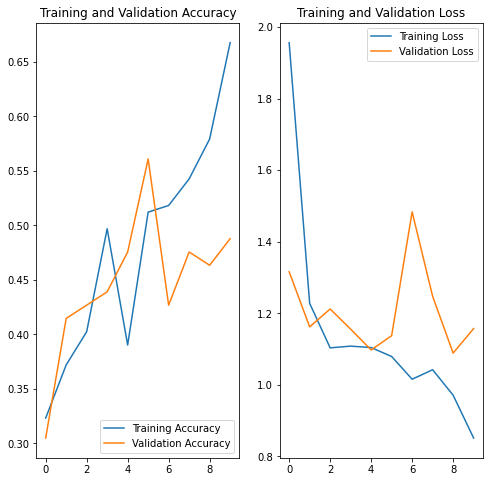

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from google.colab import files
file_to_predict = files.upload()

Saving 20211220_180913.jpg to 20211220_180913.jpg


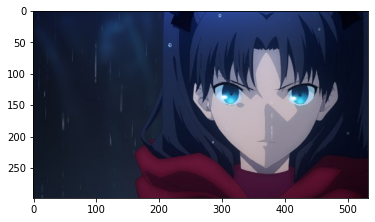

In [ ]:
for file_ in file_to_predict:
    image_to_predict = cv.imread(file_,cv.IMREAD_COLOR)
    plt.imshow(cv.cvtColor(image_to_predict, cv.COLOR_BGR2RGB))
    plt.show()

In [ ]:
img = cv.resize(image_to_predict, (290,290))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Ishtar with a 55.35 percent confidence.
